In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gensim.downloader as api
import seaborn as sns
from scipy.stats import ttest_rel
from framework import WordleAnalyzer

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional: for multilingual WordNet data
nltk.download('punkt')     # Optional: for tokenization

from nltk.corpus import wordnet as wn

# Function to get the synsets of the word
def get_synsets(word):
    return wn.synsets(word)

def calc_path_similarity(word1, word2):
    synsets1 = get_synsets(word1)
    synsets2 = get_synsets(word2)
    
    # Ensure words have synsets (not all words exist in WordNet)
    if not synsets1 or not synsets2:
        return -1000
    
    # Initialize maximum similarity
    max_sim = -1000
    
    # Iterate through all synset pairs and calculate the similarity
    for synset1 in synsets1:
        for synset2 in synsets2:
            sim = synset1.path_similarity(synset2)
            
            # Update maximum similarity found
            if sim is not None and sim > max_sim:
                max_sim = sim
    
    return max_sim

def calc_wup_similarity(word1, word2):
    synsets1 = get_synsets(word1)
    synsets2 = get_synsets(word2)
    
    # Ensure words have synsets (not all words exist in WordNet)
    if not synsets1 or not synsets2:
        return -1000
    
    # Initialize maximum similarity
    max_sim = -1000
    
    # Iterate through all synset pairs and calculate the similarity
    for synset1 in synsets1:
        for synset2 in synsets2:
            sim = synset1.wup_similarity(synset2)
            
            # Update maximum similarity found
            if sim is not None and sim > max_sim:
                max_sim = sim
    
    return max_sim

def calc_lch_similarity(word1, word2):
    synsets1 = get_synsets(word1)
    synsets2 = get_synsets(word2)
    
    # Ensure words have synsets (not all words exist in WordNet)
    if not synsets1 or not synsets2:
        return -1000
    
    # Initialize maximum similarity
    max_sim = -1000
    
    # Iterate through all synset pairs and calculate the similarity
    for synset1 in synsets1:
        for synset2 in synsets2:
            try:
                sim = synset1.lch_similarity(synset2)
            except:
                sim = None
            
            # Update maximum similarity found
            if sim is not None and sim > max_sim:
                max_sim = sim
    
    return max_sim

def get_pairwise_similarity(data, sim_function):
    human_similarity, optimal_similarity = {}, {}

    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        state = row['state']
        previous_guesses = eval(row['previous_guesses'])
        optimal_guesses = eval(row['optimal_guess'])
        human_guesses = eval(row['human_guess'])

        human_similarity[state] = []
        optimal_similarity[state] = []
        skipped = 0
        
        for i in range(len(previous_guesses)):
            prev = previous_guesses[i][-1].lower()
            opt = optimal_guesses[i].lower()
            hum = human_guesses[i].lower()
            try:
                opt_sim = sim_function(prev, opt)
                hum_sim = sim_function(prev, hum)
                if opt_sim == -1000 or hum_sim == -1000:
                    skipped += 1
                    continue
            except:
                # print(glove_distance(prev, opt, model))
                skipped += 1
                continue
            

            optimal_similarity[state].append(opt_sim)
            human_similarity[state].append(hum_sim)

        # print(f"Skipped {skipped} words for {state}")


    return human_similarity, optimal_similarity

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\garyl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\garyl\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\garyl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [13]:
# Load the pre-trained GloVe model (300 dimensions, trained on Wikipedia + Gigaword)
glove_model = api.load('glove-wiki-gigaword-300')
w2v_model = api.load('word2vec-google-news-300')

# Function to calculate cosine similarity between two vectors

# Function to compute distance between two words using GloVe
def glove_distance(word1, word2, model):
    if word1 in model and word2 in model:
        vec1 = model[word1]
        vec2 = model[word2]
        
        # Calculate Cosine Similarity
        similarity = cosine_similarity(vec1, vec2)
        distance = 1 - similarity  # Cosine distance
        
        return similarity, distance
    else:
        return f"One or both words ('{word1}', '{word2}') not found in the GloVe model."

def word2vec_distance(word1, word2, model):
    if word1 in model and word2 in model:
        vec1 = model[word1]
        vec2 = model[word2]
        
        # Calculate Cosine Similarity
        similarity = cosine_similarity(vec1, vec2)
        distance = 1 - similarity  # Cosine distance
        
        return similarity, distance
    else:
        return f"One or both words ('{word1}', '{word2}') not found in the Word2Vec model."


In [4]:
minimax = pd.read_csv('data/state_data_minimax.csv')
entropy = pd.read_csv('data/state_data.csv')

In [5]:
def get_pairwise_distance(data, sim_function, model):
    human_distance, optimal_distance = {}, {}

    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        state = row['state']
        previous_guesses = eval(row['previous_guesses'])
        optimal_guesses = eval(row['optimal_guess'])
        human_guesses = eval(row['human_guess'])

        human_distance[state] = []
        optimal_distance[state] = []
        skipped = 0
        
        for i in range(len(previous_guesses)):
            prev = previous_guesses[i][-1].lower()
            opt = optimal_guesses[i].lower()
            hum = human_guesses[i].lower()
            try:
                opt_sim, opt_dist = sim_function(prev, opt, model)
                hum_sim, hum_dist = sim_function(prev, hum, model)
            except:
                # print(glove_distance(prev, opt, model))
                skipped += 1
                continue
            

            optimal_distance[state].append(opt_dist)
            human_distance[state].append(hum_dist)

        # print(f"Skipped {skipped} words for {state}")


    return human_distance, optimal_distance


In [ ]:
def get_statistics_with_previous(data, sim_function):
    human_similarity, optimal_similarity = {}, {}

    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        state = row['state']
        previous_guesses = eval(row['previous_guesses'])
        optimal_guesses = eval(row['optimal_guess'])
        human_guesses = eval(row['human_guess'])

        human_similarity[state] = []
        optimal_similarity[state] = []
        skipped = 0
        
        for i in range(len(previous_guesses)):
            prev = previous_guesses[i].lower()
            opt = optimal_guesses[i].lower()
            hum = human_guesses[i].lower()
            hum_avg = 0
            opt_avg = 0
            for p in prev:
                hum_avg += sim_function(p, hum)
                opt_avg += sim_function(p, opt)
            opt_avg /= len(prev)
            hum_avg /= len(prev)
                    
            

            optimal_similarity[state].append(opt_avg)
            human_similarity[state].append(hum_avg)

        # print(f"Skipped {skipped} words for {state}")


    return human_similarity, optimal_similarity

In [75]:
glove_distance('dad', 'mom', w2v_model)

(0.7470093, 0.25299072265625)

In [ ]:
# print(analyze.levenshtein_between_guesses('apple', 'tester'))
# print(analyze.common_syllables('apple', 'tester'))
# print(analyze.shared_chars('apple', 'tester'))
# WordleAnalyzer.levenshtein_between_guesses

In [292]:


human_similarity, optimal_similarity = get_pairwise_similarity(entropy, WordleAnalyzer.shared_chars)
file_path = 'new_shared_chars/entropy/shared_chars'

100%|██████████| 19/19 [00:02<00:00,  7.63it/s]


In [287]:
print(len((human_similarity[14])))

26050


In [12]:
# compute cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [13]:
def prettify_state(state):
    written_state = [0] * 3
    written_state[0] = state//100
    written_state[1] = (state%100)//10
    written_state[2] = state%10
    return f'{written_state[0]}g{written_state[1]}y{written_state[2]}b'


In [104]:
print((human_similarity[14]))

[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 

In [289]:
def get_statistics(human_distance, optimal_distance, title):
    # make a new pandas dataframe, with the column names state, cohen distance, t statistic, p value, number of samples
    stats_data = pd.DataFrame(columns=['state', 'Cohen Distance', 't_statistic', 'p_value', 'num_samples', 'human_mean', 'human_std', 'optimal_mean', 'optimal_std'])


    for state in human_distance.keys():
        cohen_dist = cohen_d(human_distance[state], optimal_distance[state])
        statistic, p_value = ttest_rel(human_distance[state], optimal_distance[state])
        number = len(human_distance[state])
        human_mean = np.mean(human_distance[state])
        human_std = np.std(human_distance[state])
        optimal_mean = np.mean(optimal_distance[state])
        optimal_std = np.std(optimal_distance[state])
        stats_data = stats_data.append({'state': prettify_state(state), 'Cohen Distance': cohen_dist, 't_statistic': statistic, 'p_value': p_value, 'num_samples': number, 'human_mean': human_mean, 'human_std': human_std, 'optimal_mean': optimal_mean, 'optimal_std': optimal_std}, ignore_index=True)

    stats_data.to_csv(f'{title}_statistics.csv', index=False)
    plt.figure()
    sns.histplot(stats_data['Cohen Distance'])

    plt.savefig(f'{title}_cohen_distance.pdf', format='pdf')
    return stats_data


    # make a new pandas dataframe


C:\Users\garyl\AppData\Local\Temp\ipykernel_24376\2900110241.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_data = stats_data.append({'state': prettify_state(state), 'Cohen Distance': cohen_dist, 't_statistic': statistic, 'p_value': p_value, 'num_samples': number, 'human_mean': human_mean, 'human_std': human_std, 'optimal_mean': optimal_mean, 'optimal_std': optimal_std}, ignore_index=True)
C:\Users\garyl\AppData\Local\Temp\ipykernel_24376\2900110241.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_data = stats_data.append({'state': prettify_state(state), 'Cohen Distance': cohen_dist, 't_statistic': statistic, 'p_value': p_value, 'num_samples': number, 'human_mean': human_mean, 'human_std': human_std, 'optimal_mean': optimal_mean, 'optimal_std': optimal_std}, ignore_index=True)
C:\Users\gar

,state,Cohen Distance,t_statistic,p_value,num_samples,human_mean,human_std,optimal_mean,optimal_std
0,0g1y4b,0.940094,108.430039,0.000000e+00,26050,0.883148,0.390202,0.460038,0.502848
1,0g2y3b,0.851723,90.368497,0.000000e+00,22307,1.824584,0.593920,1.260725,0.723716
2,0g3y2b,0.783828,58.006824,0.000000e+00,10678,2.854093,0.624219,2.229912,0.937280
3,3g0y2b,0.637391,69.491499,0.000000e+00,21859,2.894506,0.465996,2.377831,1.047360
4,0g0y5b,0.157064,12.814194,2.291846e-37,13067,0.038647,0.214904,0.011709,0.112442
5,1g0y4b,1.470616,130.799313,0.000000e+00,14804,0.917860,0.350639,0.308092,0.469970
6,2g0y3b,1.033216,95.063082,0.000000e+00,15731,1.910559,0.429889,1.191278,0.885665
7,1g1y3b,1.016142,110.235338,0.000000e+00,21912,1.858525,0.525952,1.146860,0.839247
8,4g0y1b,0.435333,51.433290,0.000000e+00,20774,3.796958,0.577555,3.407625,1.125174
9,3g1y1b,0.259709,15.559713,2.621046e-53,4843,3.858972,0.420092,3.695643,0.783815


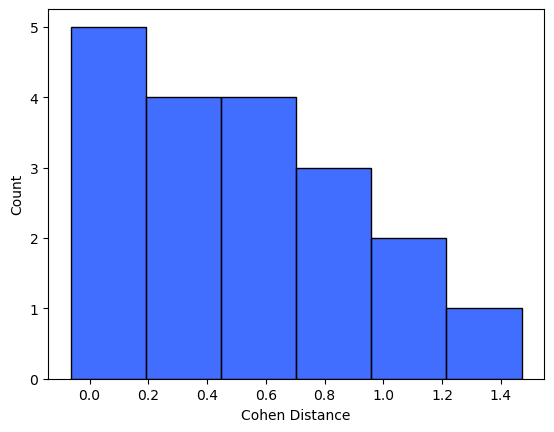

In [291]:
get_statistics(human_similarity, optimal_similarity, file_path)

In [293]:
print(len(human_similarity[14]))

26050


In [294]:
min = 1
max = 0
for state, value in human_similarity.items():
    for v in value:
        if v < min:
            min = v
        if v > max:
            max = v

for state, value in optimal_similarity.items():
    for v in value:
        if v < min:
            min = v
        if v > max:
            max = v

print(min, max)
print(human_similarity.keys())

0 5
dict_keys([14, 23, 32, 302, 5, 104, 203, 113, 401, 311, 212, 122, 41, 221, 131, 320, 140, 230, 50])


In [284]:
def graph_histograms(state, human_distance, optimal_distance, title, x_axis, type, discrete=False):
    plt.figure()
    sns.set_palette("bright")
    data = pd.DataFrame({x_axis: human_distance[state] + optimal_distance[state], type: ['Human']*len(human_distance[state]) + ['Optimal']*len(optimal_distance[state])})
    sns.histplot(data=data, x=x_axis, hue=type, discrete=discrete, multiple='layer', shrink=0.8)
    plt.text(0.5, 1, f"Cohen's distance: {cohen_d(human_distance[state], optimal_distance[state]):.{3}g}, p-value: {ttest_rel(human_distance[state], optimal_distance[state]).pvalue:.{3}g}", horizontalalignment='center', verticalalignment='bottom', transform=plt.gca().transAxes, fontsize=10)

    plt.savefig(f'{title}_histogram_{prettify_state(state)}.pdf', format='pdf')
    print(f'Cohens d {cohen_d(human_distance[state], optimal_distance[state])}')

In [ ]:
sns.histplot()

Cohens d 0.9400935704698399
Cohens d 0.8517227310788398
Cohens d 0.7838276911956856
Cohens d 0.637391060768911
Cohens d 0.1570641135716602
Cohens d 1.4706158853902398
Cohens d 1.0332159195559534
Cohens d 1.0161424281255282
Cohens d 0.4353331710874854
Cohens d 0.25970891449325323
Cohens d 0.5733287260768982
Cohens d 0.6364613935529692
Cohens d 0.5545701195929222
Cohens d 0.28939068976668
Cohens d 0.4049416016377927
Cohens d -0.01169027289490583
Cohens d -0.01019887327325302
Cohens d 0.0
Cohens d -0.06431743600805226


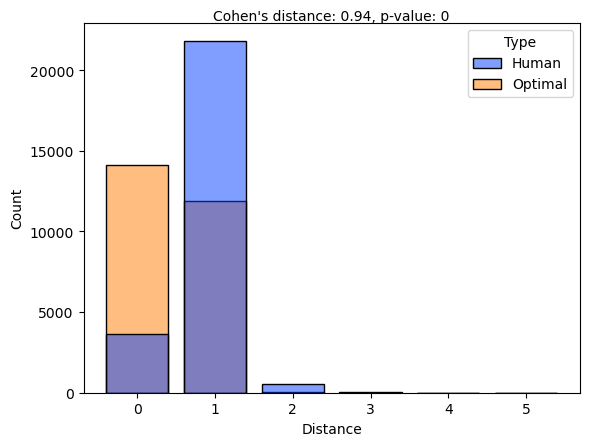

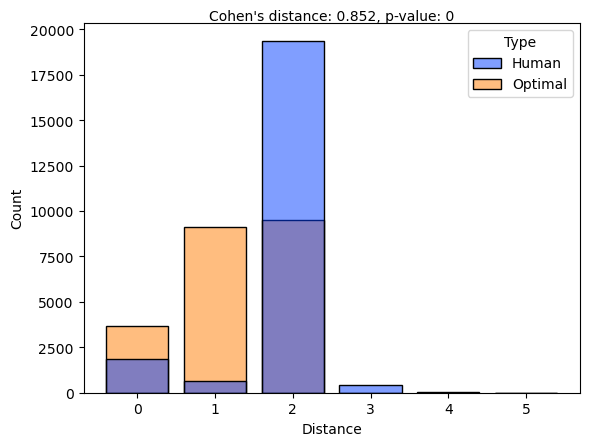

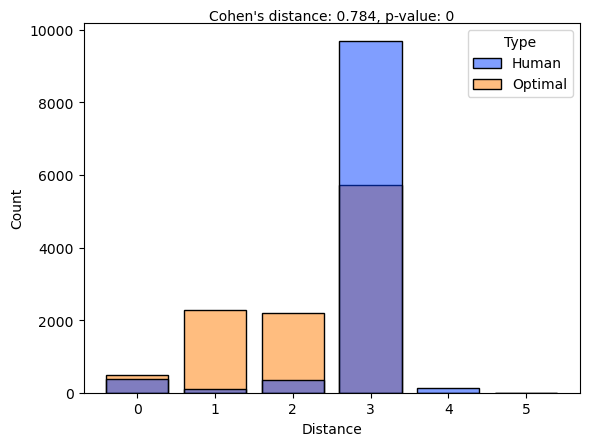

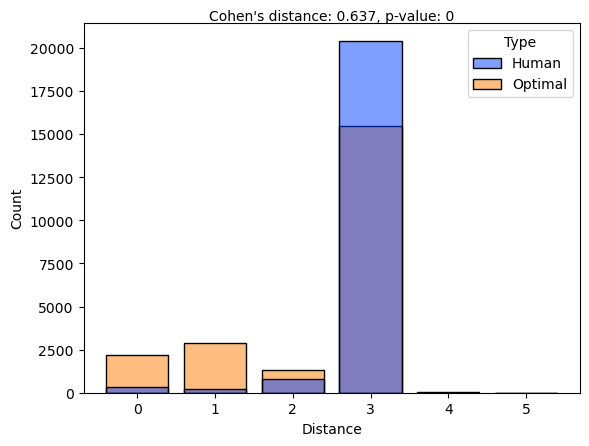

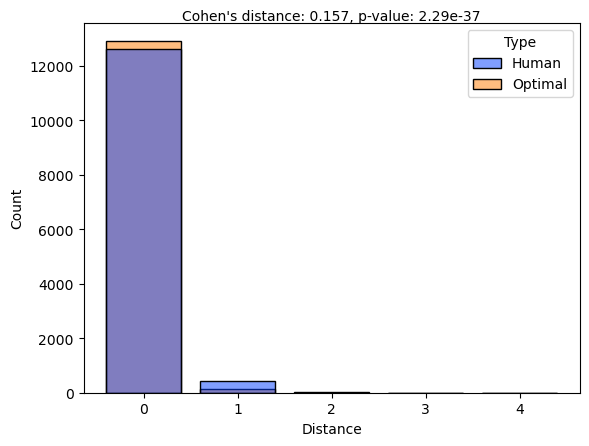

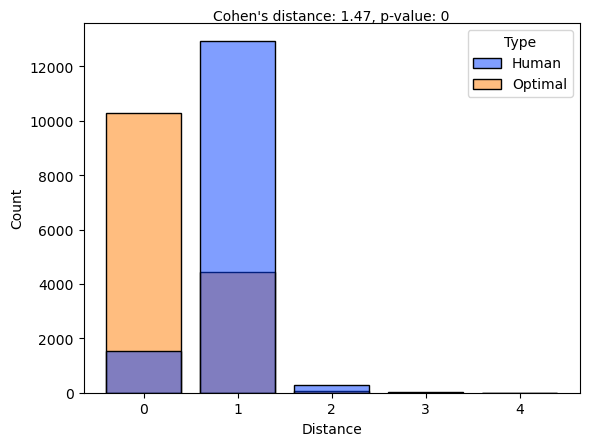

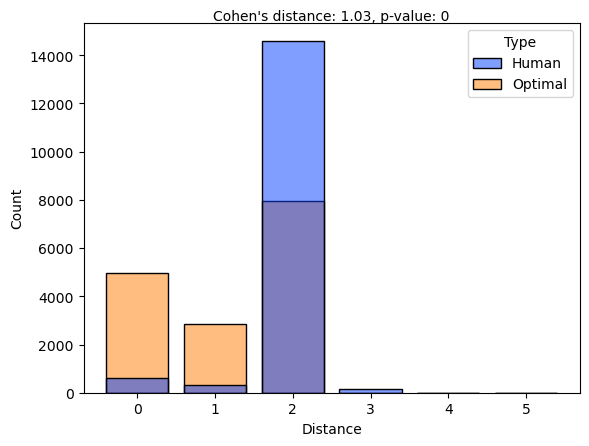

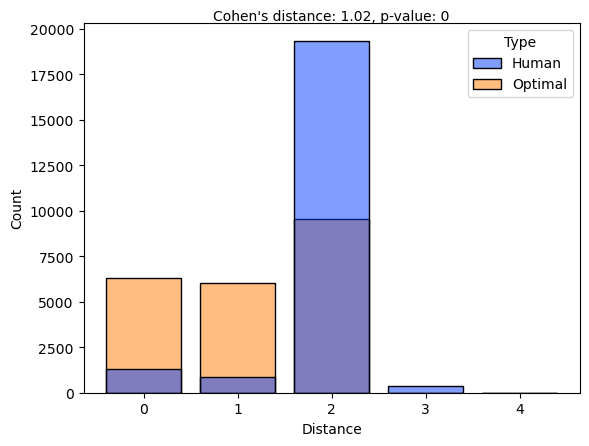

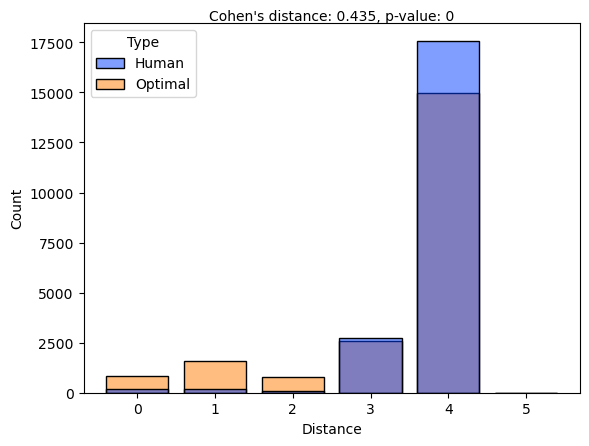

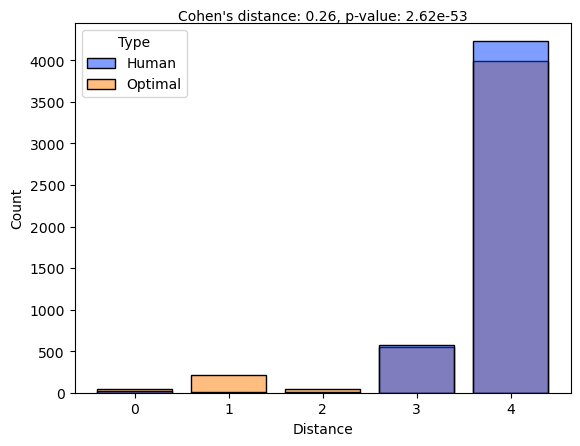

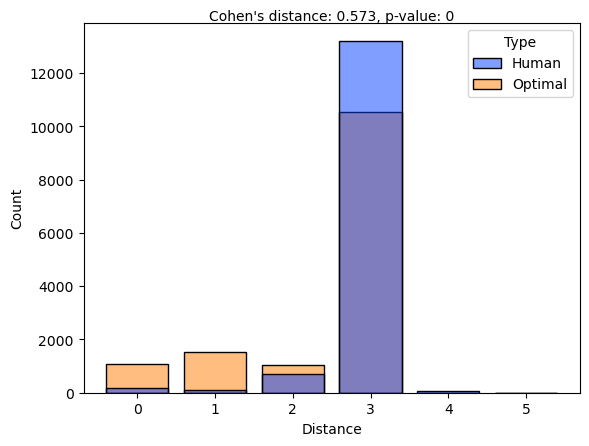

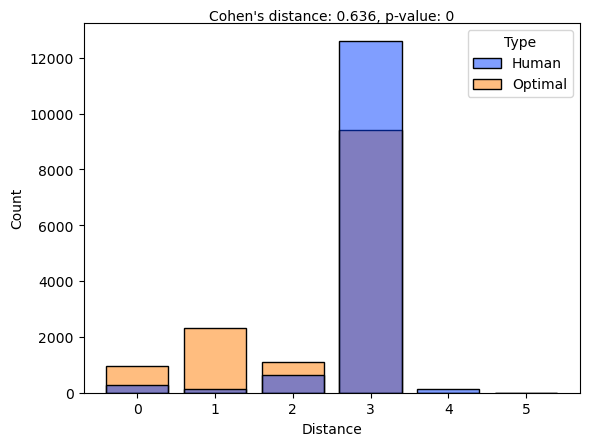

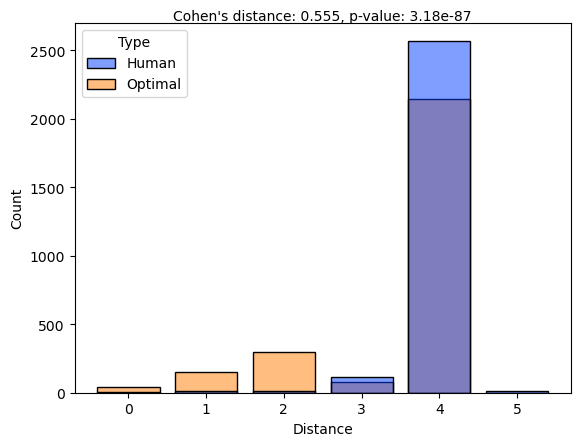

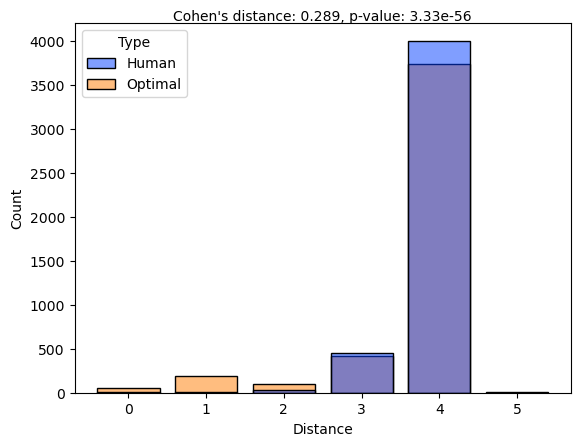

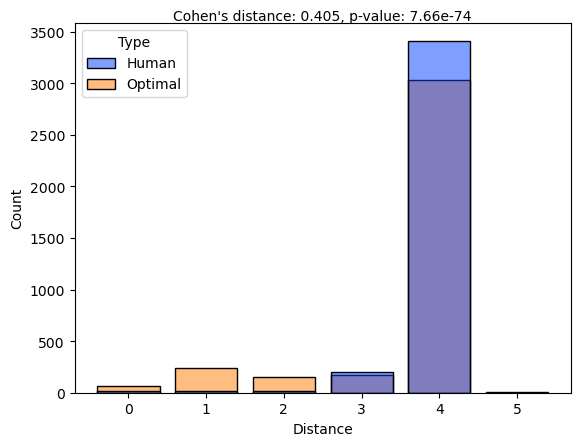

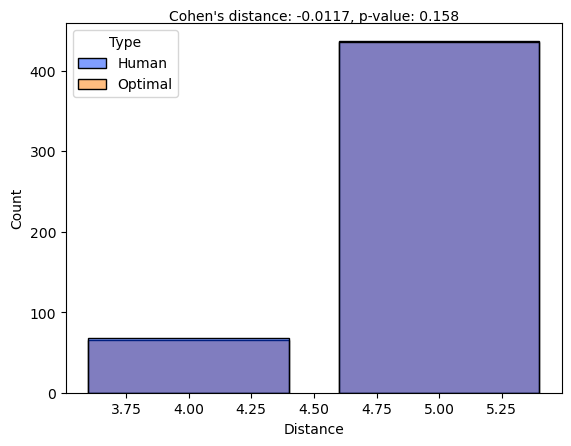

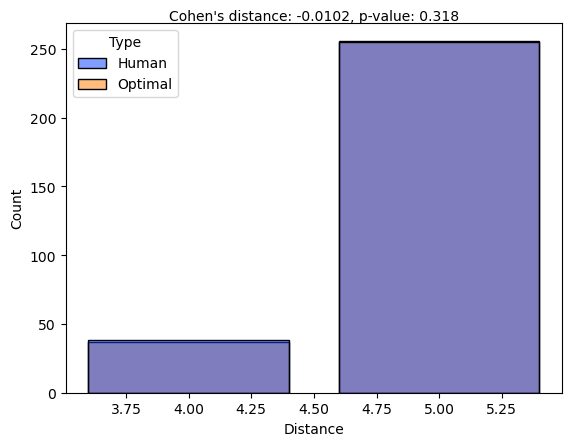

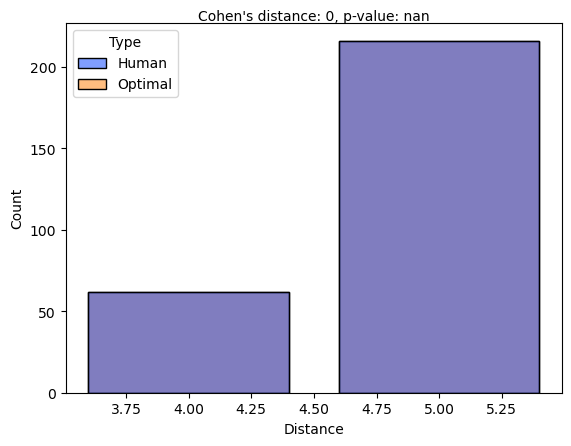

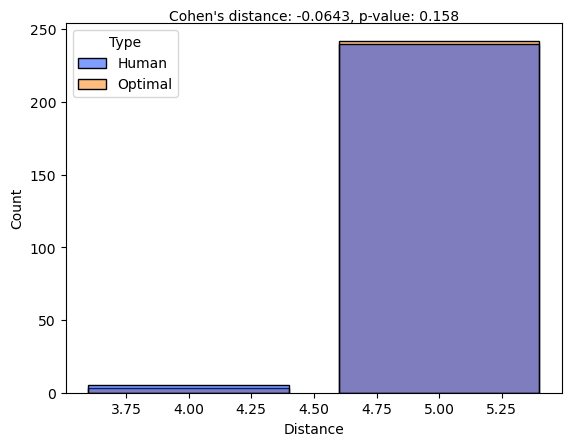

In [285]:
for state in human_similarity.keys():
    graph_histograms(state, human_similarity, optimal_similarity, file_path, "Distance", "Type", discrete=True, mult = 'dodge')

Cohens d 0.005393884332334761


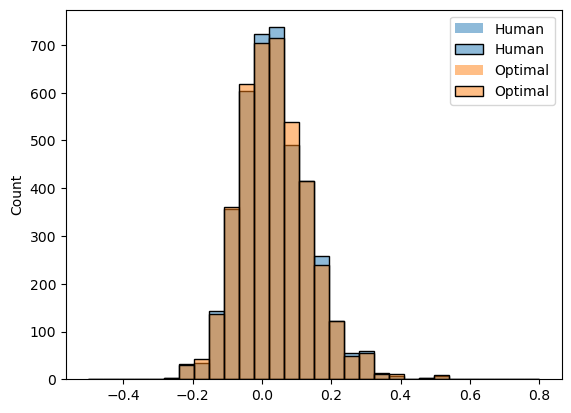

In [141]:
graph_histograms(221)

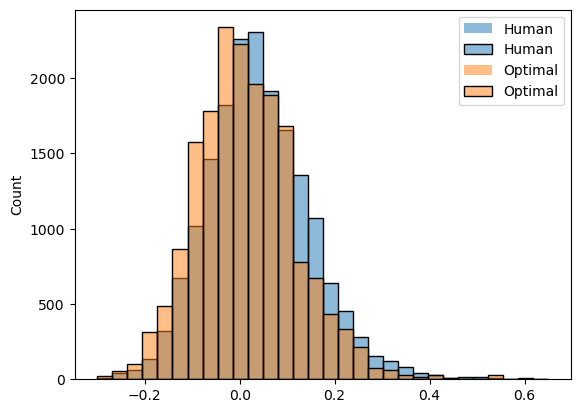

In [111]:
import seaborn as sns
# I want to generate histograms of optimal_similary[14] and human_similarity[14] in one coll
# sns.histplot(human_similarity[14], bins=30, alpha=0.5, label='Human')
# sns.histplot(optimal_similarity[14], bins=30, alpha=0.5, label='Optimal')

# I want a histogram that is normalized to 0 to 1
# subsample 5000 random indices from the human_similarity[14] and optimal_similarity[14]
idx = np.random.choice(len(human_similarity[14]), len(human_similarity[14]), replace=False)
human_similarity_subsample = [human_similarity[14][i] for i in idx]
optimal_similarity_subsample = [optimal_similarity[14][i] for i in idx]
# sns.histplot(human_similarity_subsample, bins=(), alpha=0.5, label='Human', stat = 'count')
# sns.histplot(optimal_similarity_subsample, bins=30, alpha=0.5, label='Optimal', stat = 'count', color = None)

# the range is from -0.3 to 0.65, want 30 evenly spaced bins for both histograms
sns.histplot(human_similarity[14], binrange=[-0.3, 0.65], bins=30, alpha=0.5, label='Human', stat = 'count')
sns.histplot(optimal_similarity[14], binrange=[-0.3, 0.65], bins=30, alpha=0.5, label='Optimal', stat = 'count', color = None)

# only include first and third label in legend
plt.legend()

